In [139]:
# file2 = "../remote/Silicon_etch.off"
# file1 = "../remote/Nitride_etch.obj"
file1 = "../initial_struct_600_600.off"
file2 = "../remote/BACKWARD_EULER_64_Silicon_etch.off"
file3 = "../remote/CRANK_NICOLSON_64_Silicon_etch.off"
file4 = "../remote/RUNGE_KUTTA_3_2_Silicon_etch.off"

In [140]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.distance import directed_hausdorff
from scipy import interpolate
from trimesh.registration import mesh_other
import pandas as pd
import seaborn as sns
from itertools import combinations

def load_mesh(file_path):
    """Load a mesh from file path"""
    mesh = trimesh.load(file_path, force='mesh', maintain_order=True)
    if not isinstance(mesh, trimesh.Trimesh):
        raise TypeError("Loaded file is not a valid mesh.")
    return mesh

def slice_mesh(mesh, y_level):
    """Slice mesh at specified Y level"""
    plane_origin = np.array([0.0, y_level, 0.0])
    plane_normal = np.array([0.0, 1.0, 0.0])
    slice_section = mesh.section(plane_origin=plane_origin, plane_normal=plane_normal)
    
    if slice_section is None:
        print(f"No intersection at y = {y_level}")
        return None
    
    slice_2D, to_3D = slice_section.to_planar()
    return slice_2D

def extract_contour_points(slice_2D, num_points=100):
    """Extract and normalize contour points"""
    if slice_2D is None:
        return None
    
    contours = slice_2D.discrete
    if not contours:
        return None
    
    # Get the longest contour (main shape)
    longest_contour = max(contours, key=len)
    points = np.array(longest_contour)
    
    # Resample to fixed number of points for fair comparison
    if len(points) > num_points:
        # Interpolate to reduce points
        indices = np.linspace(0, len(points)-1, num_points, dtype=int)
        points = points[indices]
    elif len(points) < num_points:
        # Interpolate to add points
        t = np.linspace(0, 1, len(points))
        t_new = np.linspace(0, 1, num_points)
        fx = interpolate.interp1d(t, points[:, 0], kind='linear')
        fy = interpolate.interp1d(t, points[:, 1], kind='linear')
        points = np.column_stack([fx(t_new), fy(t_new)])
    
    return points

def normalize_contour(points):
    """Normalize contour to unit scale and center at origin"""
    if points is None or len(points) == 0:
        return None
    
    # Center at origin
    centroid = np.mean(points, axis=0)
    centered = points - centroid
    
    # Scale to unit size
    max_dist = np.max(np.linalg.norm(centered, axis=1))
    if max_dist > 0:
        normalized = centered / max_dist
    else:
        normalized = centered
    
    return normalized

def calculate_similarity_metrics(contour1, contour2):
    """Calculate multiple similarity metrics between contours"""
    metrics = {}
    
    if contour1 is None or contour2 is None:
        return {"error": "One or both contours are None"}
    
    try:
        # Convert to OpenCV format for some calculations
        c1_cv = contour1.reshape(-1, 1, 2).astype(np.float32)
        c2_cv = contour2.reshape(-1, 1, 2).astype(np.float32)
        
        # 1. Hausdorff Distance (normalized)
        hausdorff_dist = max(
            directed_hausdorff(contour1, contour2)[0],
            directed_hausdorff(contour2, contour1)[0]
        )
        metrics['hausdorff_distance'] = hausdorff_dist
        
        # 2. Area difference (relative)
        area1 = abs(cv2.contourArea(c1_cv))
        area2 = abs(cv2.contourArea(c2_cv))
        max_area = max(area1, area2)
        area_diff = abs(area1 - area2) / max_area if max_area > 0 else 0
        metrics['area_difference'] = area_diff
        
        # 3. OpenCV Hu Moments matching (lower is better)
        try:
            hu_distance = cv2.matchShapes(c1_cv, c2_cv, cv2.CONTOURS_MATCH_I1, 0.0)
            metrics['hu_moments_distance'] = hu_distance
        except Exception as e:
            metrics['hu_moments_error'] = str(e)
        
        # 4. Shape Context Distance (REQUIRED)
        shape_context_dist = None
        try:
            extractor = cv2.createShapeContextDistanceExtractor()
            shape_context_dist = extractor.computeDistance(c1_cv, c2_cv)
            metrics['shape_context_distance'] = shape_context_dist
        except Exception as e:
            metrics['shape_context_error'] = str(e)
            # If shape context fails, return error immediately since it's required
            return {"error": f"Shape Context calculation failed (required): {str(e)}"}
        
        # 5. Perimeter ratio
        perimeter1 = cv2.arcLength(c1_cv, True)
        perimeter2 = cv2.arcLength(c2_cv, True)
        max_perimeter = max(perimeter1, perimeter2)
        perimeter_ratio = min(perimeter1, perimeter2) / max_perimeter if max_perimeter > 0 else 0
        metrics['perimeter_ratio'] = perimeter_ratio
        
        # 6. Enhanced Similarity Score (0-1, where 1 is identical)
        # MANDATORY: Shape Context must be included in similarity calculation
        if shape_context_dist is None:
            return {"error": "Shape Context Distance is required but not available"}
        
        # Convert distances to similarities properly
        similarity_components = []
        weights = []
        
        # Hausdorff similarity: use exponential decay for distance-to-similarity conversion
        hausdorff_similarity = np.exp(-hausdorff_dist * 2)  # 2 is sensitivity parameter
        similarity_components.append(hausdorff_similarity)
        weights.append(0.2)  # Reduced weight to accommodate mandatory shape context
        
        # Area similarity (already a proper similarity measure)
        area_similarity = 1 - area_diff
        similarity_components.append(area_similarity)
        weights.append(0.15)  # Reduced weight
        
        # Perimeter similarity
        perimeter_similarity = perimeter_ratio  # Already a ratio (similarity measure)
        similarity_components.append(perimeter_similarity)
        weights.append(0.15)  # Reduced weight
        
        # MANDATORY Shape Context similarity
        # Convert Shape Context distance to similarity using exponential decay
        # Shape context distances are typically larger, so use a smaller decay factor
        shape_context_similarity = np.exp(-shape_context_dist * 0.5)
        similarity_components.append(shape_context_similarity)
        weights.append(0.35)  # High weight for mandatory shape context
        
        # Add Hu moments similarity if available (optional)
        if 'hu_moments_distance' in metrics and hu_distance < 10:  # Reasonable range check
            # Convert Hu moments distance to similarity using exponential decay
            hu_similarity = np.exp(-hu_distance)
            similarity_components.append(hu_similarity)
            weights.append(0.15)  # Remaining weight for Hu moments
        
        # Normalize weights to sum to 1
        total_weight = sum(weights)
        if total_weight > 0:
            normalized_weights = [w / total_weight for w in weights]
        else:
            normalized_weights = [1.0 / len(weights)] * len(weights)
        
        # Combined similarity score (weighted average)
        similarity_score = sum(sim * weight for sim, weight in zip(similarity_components, normalized_weights))
        metrics['similarity_score'] = max(0, min(1, similarity_score))
        
        # Store information about which metrics were used
        metrics['metrics_used'] = {
            'hausdorff': True,
            'area': True,
            'perimeter': True,
            'shape_context': True,  # Always True now
            'hu_moments': 'hu_moments_distance' in metrics and hu_distance < 10
        }
        
        # Store the individual similarity components for debugging
        metrics['similarity_components'] = {
            'hausdorff_similarity': hausdorff_similarity,
            'area_similarity': area_similarity,
            'perimeter_similarity': perimeter_similarity,
            'shape_context_similarity': shape_context_similarity  # Always included
        }
        
        if 'hu_moments_distance' in metrics and hu_distance < 10:
            metrics['similarity_components']['hu_similarity'] = np.exp(-hu_distance)
        
        # Create weight labels dynamically based on what's included
        weight_labels = ['hausdorff', 'area', 'perimeter', 'shape_context']
        if 'hu_moments_distance' in metrics and hu_distance < 10:
            weight_labels.append('hu_moments')
            
        metrics['final_weights'] = dict(zip(weight_labels, normalized_weights))
        
    except Exception as e:
        metrics['calculation_error'] = str(e)
    
    return metrics

def plot_four_model_comparison(contours, metrics_matrix, labels, y_slice_value=None):
    """Create comprehensive 4-model comparison visualization"""
    fig = plt.figure(figsize=(20, 16))
    
    title = f"Four-Model Contour Comparison Analysis"
    if y_slice_value is not None:
        title += f" (Y-slice: {y_slice_value})"
    fig.suptitle(title, fontsize=18, fontweight='bold')
    
    # Define colors for each model
    colors = ['red', 'blue', 'green', 'orange']
    alphas = [0.7, 0.7, 0.7, 0.7]
    
    # Create grid layout
    gs = fig.add_gridspec(3, 4, height_ratios=[2, 2, 1.5], hspace=0.3, wspace=0.3)
    
    # Top row: Individual contours
    for i in range(4):
        ax = fig.add_subplot(gs[0, i])
        if contours[i] is not None:
            ax.plot(contours[i][:, 0], contours[i][:, 1], 
                   color=colors[i], linewidth=2, label=labels[i])
            ax.fill(contours[i][:, 0], contours[i][:, 1], 
                   color=colors[i], alpha=0.2)
        ax.set_title(f"{labels[i]}", fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        ax.set_xlabel("X")
        ax.set_ylabel("Z")
    
    # Middle row: Pairwise overlays (6 comparisons)
    overlay_positions = [(1, 0), (1, 1), (1, 2), (1, 3)]
    comparison_pairs = list(combinations(range(4), 2))
    
    # Show first 4 most important comparisons
    important_comparisons = comparison_pairs[:4]
    
    for idx, (i, j) in enumerate(important_comparisons):
        ax = fig.add_subplot(gs[1, idx])
        
        if contours[i] is not None:
            ax.plot(contours[i][:, 0], contours[i][:, 1], 
                   color=colors[i], linewidth=2, label=labels[i], alpha=alphas[i])
            ax.scatter(contours[i][:, 0], contours[i][:, 1], 
                      c=colors[i], s=15, alpha=0.6)
        
        if contours[j] is not None:
            ax.plot(contours[j][:, 0], contours[j][:, 1], 
                   color=colors[j], linewidth=2, label=labels[j], alpha=alphas[j])
            ax.scatter(contours[j][:, 0], contours[j][:, 1], 
                      c=colors[j], s=15, alpha=0.6)
        
        # Add similarity score to title
        similarity = metrics_matrix[i][j].get('similarity_score', 0)
        ax.set_title(f"{labels[i]} vs {labels[j]}\nSimilarity: {similarity:.3f}")
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        ax.set_xlabel("X")
        ax.set_ylabel("Z")
    
    # Bottom section: Similarity matrix and statistics
    ax_matrix = fig.add_subplot(gs[2, :2])
    ax_stats = fig.add_subplot(gs[2, 2:])
    
    # Create similarity matrix for heatmap
    similarity_matrix = np.ones((4, 4))
    for i in range(4):
        for j in range(4):
            if i != j:
                similarity_matrix[i][j] = metrics_matrix[i][j].get('similarity_score', 0)
    
    # Plot similarity heatmap
    im = ax_matrix.imshow(similarity_matrix, cmap='RdYlGn', vmin=0, vmax=1)
    ax_matrix.set_xticks(range(4))
    ax_matrix.set_yticks(range(4))
    ax_matrix.set_xticklabels(labels)
    ax_matrix.set_yticklabels(labels)
    ax_matrix.set_title("Similarity Matrix", fontweight='bold')
    
    # Add text annotations to heatmap
    for i in range(4):
        for j in range(4):
            if i != j:
                score = similarity_matrix[i][j]
                color = 'white' if score < 0.5 else 'black'
                ax_matrix.text(j, i, f'{score:.3f}', ha='center', va='center', 
                             color=color, fontweight='bold')
            else:
                ax_matrix.text(j, i, '1.000', ha='center', va='center', 
                             color='black', fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax_matrix, shrink=0.8)
    cbar.set_label('Similarity Score', rotation=270, labelpad=15)
    
    # Statistics panel
    ax_stats.axis('off')
    ax_stats.set_title("Comparison Statistics", fontweight='bold')
    
    # Calculate statistics
    all_similarities = []
    for i in range(4):
        for j in range(i+1, 4):
            sim_score = metrics_matrix[i][j].get('similarity_score', 0)
            all_similarities.append(sim_score)
    
    if all_similarities:
        avg_similarity = np.mean(all_similarities)
        std_similarity = np.std(all_similarities)
        min_similarity = np.min(all_similarities)
        max_similarity = np.max(all_similarities)
        
        # Find most and least similar pairs
        max_idx = np.argmax(all_similarities)
        min_idx = np.argmin(all_similarities)
        
        pair_indices = list(combinations(range(4), 2))
        most_similar_pair = pair_indices[max_idx]
        least_similar_pair = pair_indices[min_idx]
        
        stats_text = f"Overall Statistics:\n"
        stats_text += f"Average Similarity: {avg_similarity:.3f} ± {std_similarity:.3f}\n"
        stats_text += f"Range: {min_similarity:.3f} - {max_similarity:.3f}\n\n"
        stats_text += f"Most Similar Pair:\n"
        stats_text += f"{labels[most_similar_pair[0]]} vs {labels[most_similar_pair[1]]}\n"
        stats_text += f"Score: {max_similarity:.3f}\n\n"
        stats_text += f"Least Similar Pair:\n"
        stats_text += f"{labels[least_similar_pair[0]]} vs {labels[least_similar_pair[1]]}\n"
        stats_text += f"Score: {min_similarity:.3f}\n\n"
        
        # Add interpretation
        if avg_similarity > 0.8:
            interpretation = "Models are generally similar"
        elif avg_similarity > 0.6:
            interpretation = "Models show moderate similarity"
        elif avg_similarity > 0.4:
            interpretation = "Models are somewhat different"
        else:
            interpretation = "Models are quite different"
        
        stats_text += f"Interpretation: {interpretation}"
        
        ax_stats.text(0.05, 0.95, stats_text, transform=ax_stats.transAxes, 
                     fontsize=10, verticalalignment='top', fontfamily='monospace',
                     bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def create_similarity_report(metrics_matrix, labels):
    """Create a detailed similarity report as a DataFrame"""
    n_models = len(labels)
    comparison_data = []
    
    for i in range(n_models):
        for j in range(i+1, n_models):
            metrics = metrics_matrix[i][j]
            
            if 'error' not in metrics:
                comparison_data.append({
                    'Model_A': labels[i],
                    'Model_B': labels[j],
                    'Similarity_Score': metrics.get('similarity_score', 0),
                    'Hausdorff_Distance': metrics.get('hausdorff_distance', 0),
                    'Area_Difference': metrics.get('area_difference', 0),
                    'Perimeter_Ratio': metrics.get('perimeter_ratio', 0),
                    'Shape_Context_Distance': metrics.get('shape_context_distance', 0),
                    'Hu_Moments_Distance': metrics.get('hu_moments_distance', 'N/A')
                })
    
    df = pd.DataFrame(comparison_data)
    return df

def compare_four_meshes(file_paths, y_slice_value=100, labels=None, num_points=100):
    """Main function to compare contours from four mesh files"""
    if len(file_paths) != 4:
        raise ValueError("Exactly 4 file paths must be provided")
    
    if labels is None:
        labels = [f"Model {i+1}" for i in range(4)]
    elif len(labels) != 4:
        raise ValueError("Exactly 4 labels must be provided")
    
    print(f"Loading 4 meshes and extracting contours at Y = {y_slice_value}...")
    
    try:
        # Load all meshes
        meshes = []
        for i, file_path in enumerate(file_paths):
            print(f"Loading {labels[i]}: {file_path}")
            mesh = load_mesh(file_path)
            meshes.append(mesh)
        
        # Register all meshes to the first one for consistency
        print("Registering meshes for consistent alignment...")
        reference_mesh = meshes[0]
        
        for i in range(1, 4):
            try:
                T, cost = mesh_other(meshes[i], reference_mesh,
                                   samples=1000,
                                   scale=False,
                                   icp_first=10,
                                   icp_final=50)
                meshes[i].apply_transform(T)
                print(f"  Registered {labels[i]} with cost: {cost:.4f}")
            except Exception as e:
                print(f"  Warning: Could not register {labels[i]}: {e}")
        
        # Extract cross sections
        contours_raw = []
        contours_normalized = []
        
        for i, mesh in enumerate(meshes):
            cross_section = slice_mesh(mesh, y_slice_value)
            contour_raw = extract_contour_points(cross_section, num_points)
            contour_normalized = normalize_contour(contour_raw)
            
            contours_raw.append(contour_raw)
            contours_normalized.append(contour_normalized)
            
            if contour_normalized is not None:
                print(f"  {labels[i]}: {len(contour_normalized)} points extracted")
            else:
                print(f"  {labels[i]}: Failed to extract contour")
        
        # Calculate all pairwise similarity metrics
        print("\nCalculating similarity metrics for all pairs...")
        metrics_matrix = [[{} for _ in range(4)] for _ in range(4)]
        
        total_comparisons = 0
        successful_comparisons = 0
        
        for i in range(4):
            for j in range(4):
                if i != j:
                    total_comparisons += 1
                    print(f"  Comparing {labels[i]} vs {labels[j]}...")
                    
                    metrics = calculate_similarity_metrics(
                        contours_normalized[i], 
                        contours_normalized[j]
                    )
                    
                    metrics_matrix[i][j] = metrics
                    
                    if 'error' not in metrics:
                        successful_comparisons += 1
                        score = metrics.get('similarity_score', 0)
                        print(f"    Similarity: {score:.3f}")
                    else:
                        print(f"    Error: {metrics['error']}")
                else:
                    # Self-comparison (perfect similarity)
                    metrics_matrix[i][j] = {'similarity_score': 1.0}
        
        print(f"\nComparison Summary: {successful_comparisons}/{total_comparisons} successful")
        
        # Create comprehensive visualization
        plot_four_model_comparison(contours_normalized, metrics_matrix, labels, y_slice_value)
        
        # Create detailed report
        similarity_report = create_similarity_report(metrics_matrix, labels)
        
        print("\nDetailed Similarity Report:")
        print("=" * 80)
        print(similarity_report.to_string(index=False, float_format='%.4f'))
        
        return {
            'metrics_matrix': metrics_matrix,
            'contours': contours_normalized,
            'similarity_report': similarity_report,
            'labels': labels
        }
        
    except Exception as e:
        print(f"Error in four-mesh comparison: {e}")
        return None

def plot_detailed_pairwise_comparisons(comparison_results):
    """Create detailed pairwise comparison plots for all 6 combinations"""
    if comparison_results is None:
        return
    
    contours = comparison_results['contours']
    metrics_matrix = comparison_results['metrics_matrix']
    labels = comparison_results['labels']
    
    # Create all pairwise combinations
    pairs = list(combinations(range(4), 2))
    
    # Create subplot grid for all 6 comparisons
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle("Detailed Pairwise Comparisons", fontsize=16, fontweight='bold')
    
    colors = ['red', 'blue', 'green', 'orange']
    
    for idx, (i, j) in enumerate(pairs):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        
        # Plot both contours
        if contours[i] is not None:
            ax.plot(contours[i][:, 0], contours[i][:, 1], 
                   color=colors[i], linewidth=2, label=labels[i], alpha=0.7)
            ax.scatter(contours[i][:, 0], contours[i][:, 1], 
                      c=colors[i], s=20, alpha=0.5)
        
        if contours[j] is not None:
            ax.plot(contours[j][:, 0], contours[j][:, 1], 
                   color=colors[j], linewidth=2, label=labels[j], alpha=0.7)
            ax.scatter(contours[j][:, 0], contours[j][:, 1], 
                      c=colors[j], s=20, alpha=0.5)
        
        # Add metrics information
        metrics = metrics_matrix[i][j]
        similarity = metrics.get('similarity_score', 0)
        hausdorff = metrics.get('hausdorff_distance', 0)
        
        title = f"{labels[i]} vs {labels[j]}\n"
        title += f"Similarity: {similarity:.3f}\n"
        title += f"Hausdorff: {hausdorff:.3f}"
        
        ax.set_title(title, fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        ax.set_xlabel("X")
        ax.set_ylabel("Z")
    
    plt.tight_layout()
    plt.show()

#

Loading 4 meshes and extracting contours at Y = -330.0...
Loading SEMulator3D: ../initial_struct_600_600.off
Loading Backward Euler: ../remote/BACKWARD_EULER_64_Silicon_etch.off
Loading CRANK-Nicolson: ../remote/CRANK_NICOLSON_64_Silicon_etch.off
Loading Rungge-Kutta3: ../remote/RUNGE_KUTTA_3_2_Silicon_etch.off
Registering meshes for consistent alignment...
  Registered Backward Euler with cost: 0.0004
  Registered CRANK-Nicolson with cost: 0.0015
  Registered Rungge-Kutta3 with cost: 0.0033
  SEMulator3D: 1000 points extracted
  Backward Euler: 1000 points extracted


/var/folders/yl/w2g1vm6x5rl_pppyvt9yfjk00000gn/T/ipykernel_8148/1820511793.py:29: DeprecationWarning: DEPRECATED: replace `path.to_planar`->`path.to_2D), removal 1/1/2026
  slice_2D, to_3D = slice_section.to_planar()


  CRANK-Nicolson: 1000 points extracted
  Rungge-Kutta3: 1000 points extracted

Calculating similarity metrics for all pairs...
  Comparing SEMulator3D vs Backward Euler...
    Similarity: 0.988
  Comparing SEMulator3D vs CRANK-Nicolson...
    Similarity: 0.985
  Comparing SEMulator3D vs Rungge-Kutta3...
    Similarity: 0.981
  Comparing Backward Euler vs SEMulator3D...
    Similarity: 0.989
  Comparing Backward Euler vs CRANK-Nicolson...
    Similarity: 0.993
  Comparing Backward Euler vs Rungge-Kutta3...
    Similarity: 0.983
  Comparing CRANK-Nicolson vs SEMulator3D...
    Similarity: 0.985
  Comparing CRANK-Nicolson vs Backward Euler...
    Similarity: 0.993
  Comparing CRANK-Nicolson vs Rungge-Kutta3...
    Similarity: 0.987
  Comparing Rungge-Kutta3 vs SEMulator3D...
    Similarity: 0.980
  Comparing Rungge-Kutta3 vs Backward Euler...
    Similarity: 0.986
  Comparing Rungge-Kutta3 vs CRANK-Nicolson...
    Similarity: 0.987

Comparison Summary: 12/12 successful


/var/folders/yl/w2g1vm6x5rl_pppyvt9yfjk00000gn/T/ipykernel_8148/1820511793.py:357: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


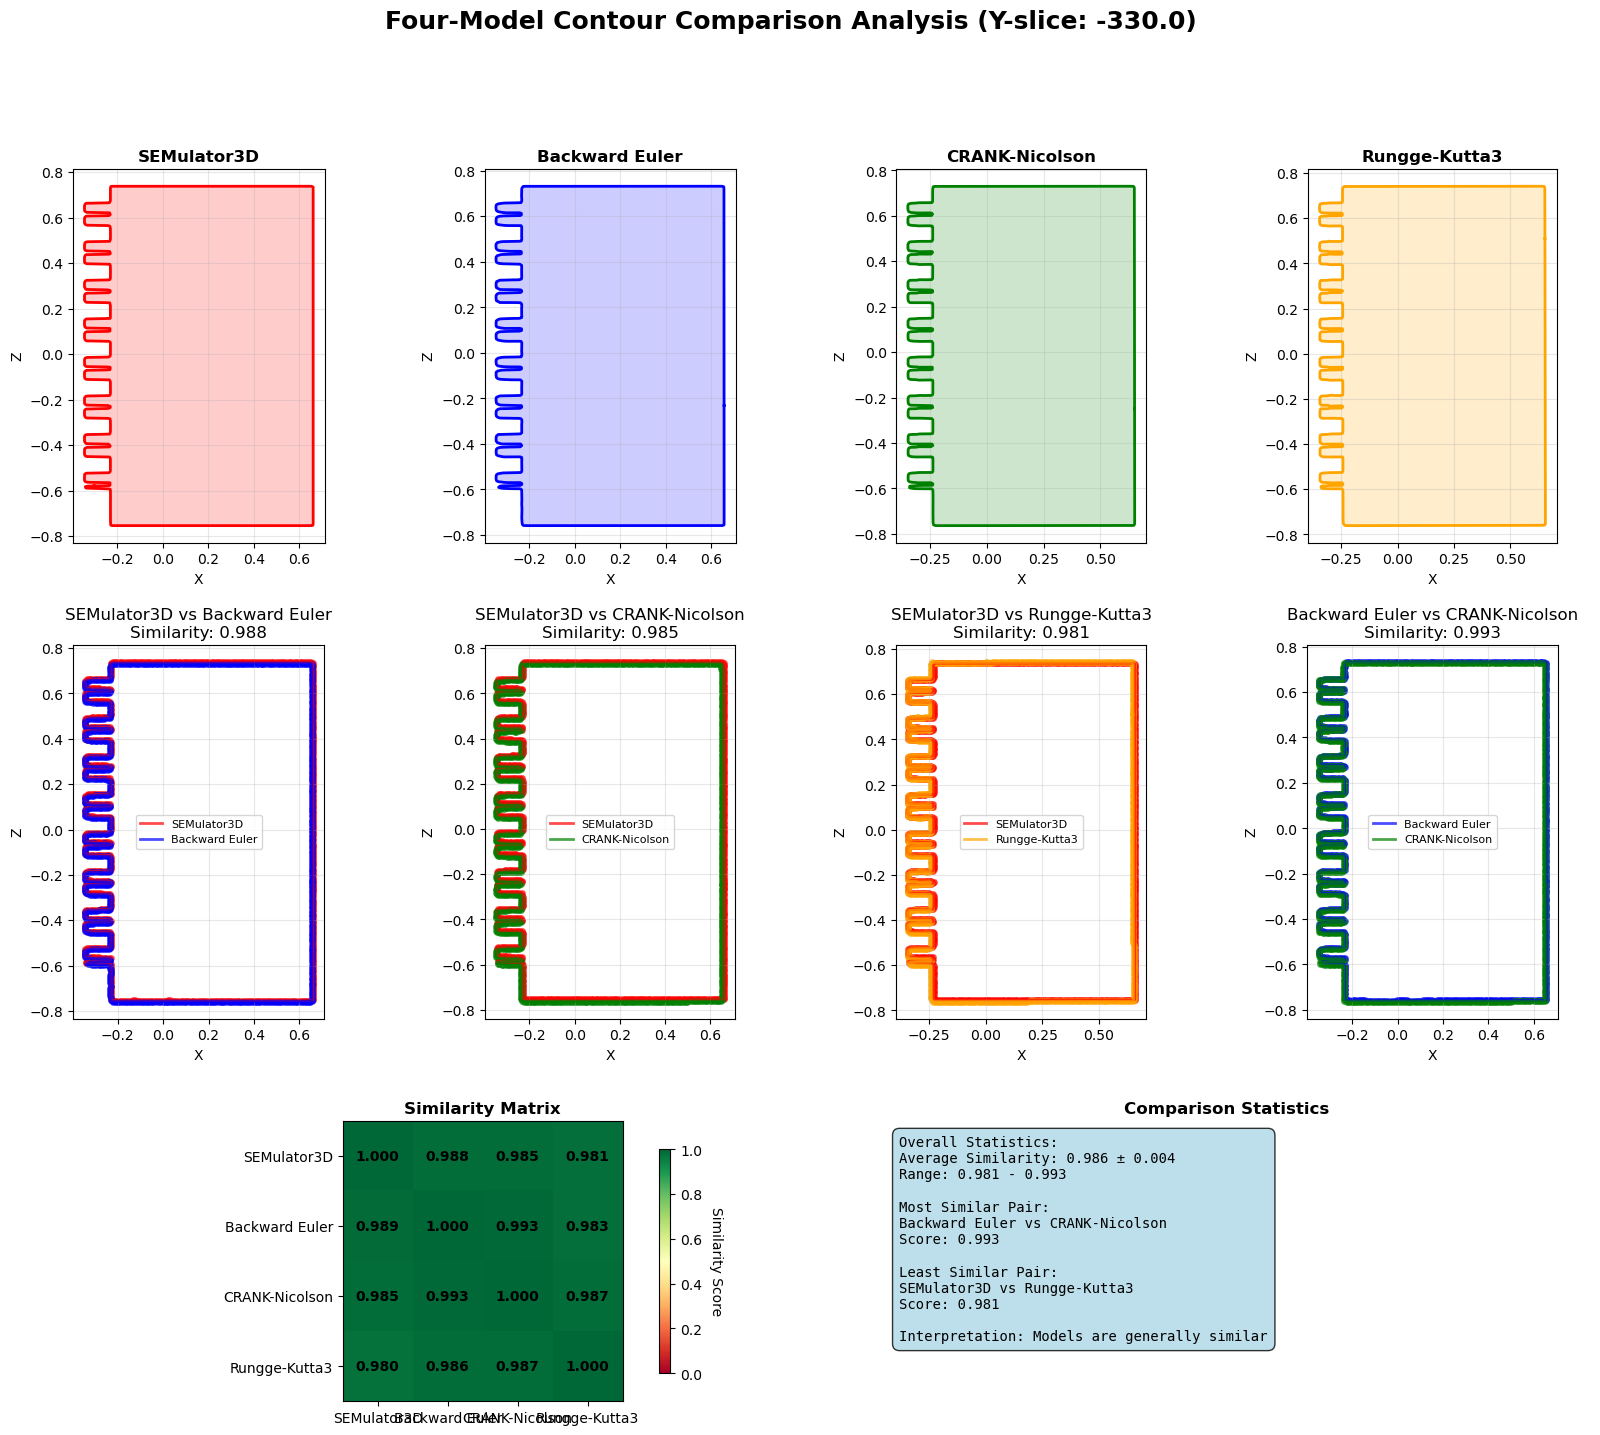


Detailed Similarity Report:
       Model_A        Model_B  Similarity_Score  Hausdorff_Distance  Area_Difference  Perimeter_Ratio  Shape_Context_Distance  Hu_Moments_Distance
   SEMulator3D Backward Euler            0.9876              0.0101           0.0044           0.9822                  0.0277               0.0019
   SEMulator3D CRANK-Nicolson            0.9847              0.0150           0.0025           0.9780                  0.0299               0.0035
   SEMulator3D  Rungge-Kutta3            0.9808              0.0142           0.0085           0.9562                  0.0296               0.0039
Backward Euler CRANK-Nicolson            0.9926              0.0086           0.0019           0.9957                  0.0162               0.0016
Backward Euler  Rungge-Kutta3            0.9835              0.0146           0.0129           0.9735                  0.0261               0.0020
CRANK-Nicolson  Rungge-Kutta3            0.9866              0.0129           0.0110     

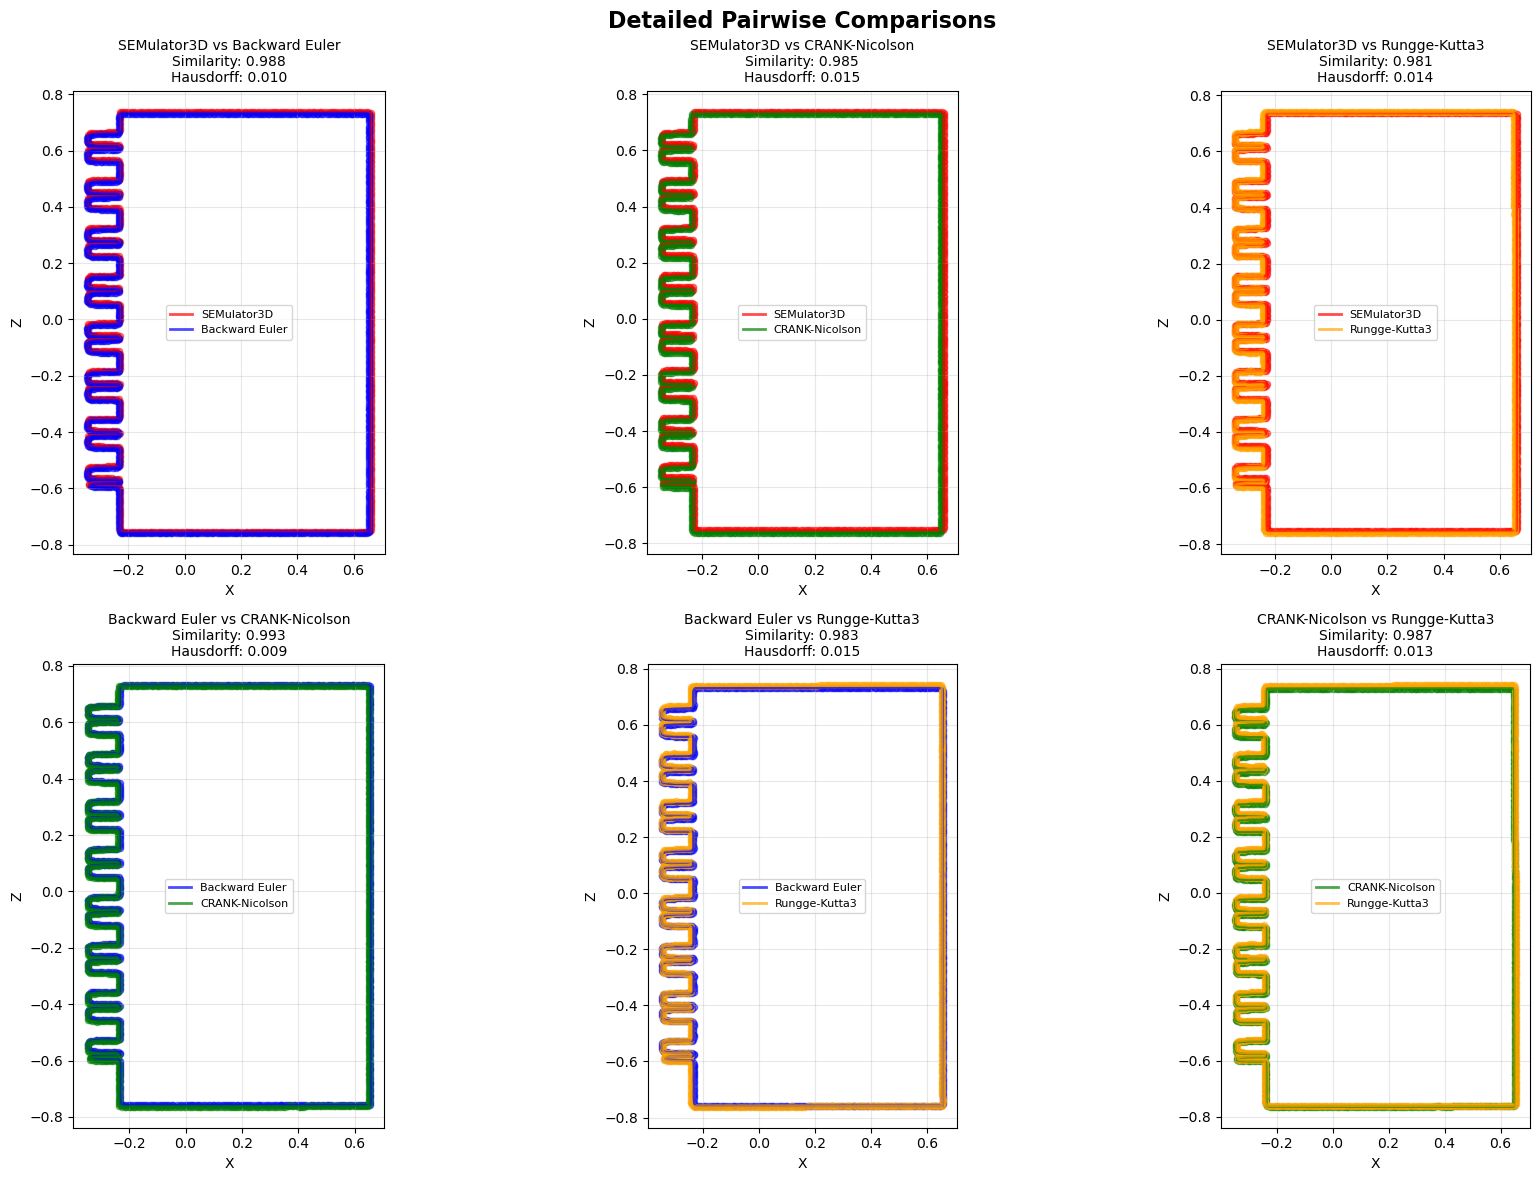


Most similar pair: Backward Euler vs CRANK-Nicolson
Similarity score: 0.9926
Loading 4 meshes and extracting contours at Y = -184.0...
Loading SEMulator3D: ../initial_struct_600_600.off
Loading Backward Euler: ../remote/BACKWARD_EULER_64_Silicon_etch.off
Loading CRANK-Nicolson: ../remote/CRANK_NICOLSON_64_Silicon_etch.off
Loading Rungge-Kutta3: ../remote/RUNGE_KUTTA_3_2_Silicon_etch.off
Registering meshes for consistent alignment...
  Registered Backward Euler with cost: 0.0003
  Registered CRANK-Nicolson with cost: 0.0014
  Registered Rungge-Kutta3 with cost: 0.0035
  SEMulator3D: 1000 points extracted
  Backward Euler: 1000 points extracted
  CRANK-Nicolson: 1000 points extracted


/var/folders/yl/w2g1vm6x5rl_pppyvt9yfjk00000gn/T/ipykernel_8148/1820511793.py:29: DeprecationWarning: DEPRECATED: replace `path.to_planar`->`path.to_2D), removal 1/1/2026
  slice_2D, to_3D = slice_section.to_planar()


  Rungge-Kutta3: 1000 points extracted

Calculating similarity metrics for all pairs...
  Comparing SEMulator3D vs Backward Euler...
    Similarity: 0.988
  Comparing SEMulator3D vs CRANK-Nicolson...
    Similarity: 0.990
  Comparing SEMulator3D vs Rungge-Kutta3...
    Similarity: 0.977
  Comparing Backward Euler vs SEMulator3D...
    Similarity: 0.990
  Comparing Backward Euler vs CRANK-Nicolson...
    Similarity: 0.990
  Comparing Backward Euler vs Rungge-Kutta3...
    Similarity: 0.983
  Comparing CRANK-Nicolson vs SEMulator3D...
    Similarity: 0.990
  Comparing CRANK-Nicolson vs Backward Euler...
    Similarity: 0.993
  Comparing CRANK-Nicolson vs Rungge-Kutta3...
    Similarity: 0.985
  Comparing Rungge-Kutta3 vs SEMulator3D...
    Similarity: 0.979
  Comparing Rungge-Kutta3 vs Backward Euler...
    Similarity: 0.986
  Comparing Rungge-Kutta3 vs CRANK-Nicolson...
    Similarity: 0.985

Comparison Summary: 12/12 successful


/var/folders/yl/w2g1vm6x5rl_pppyvt9yfjk00000gn/T/ipykernel_8148/1820511793.py:357: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


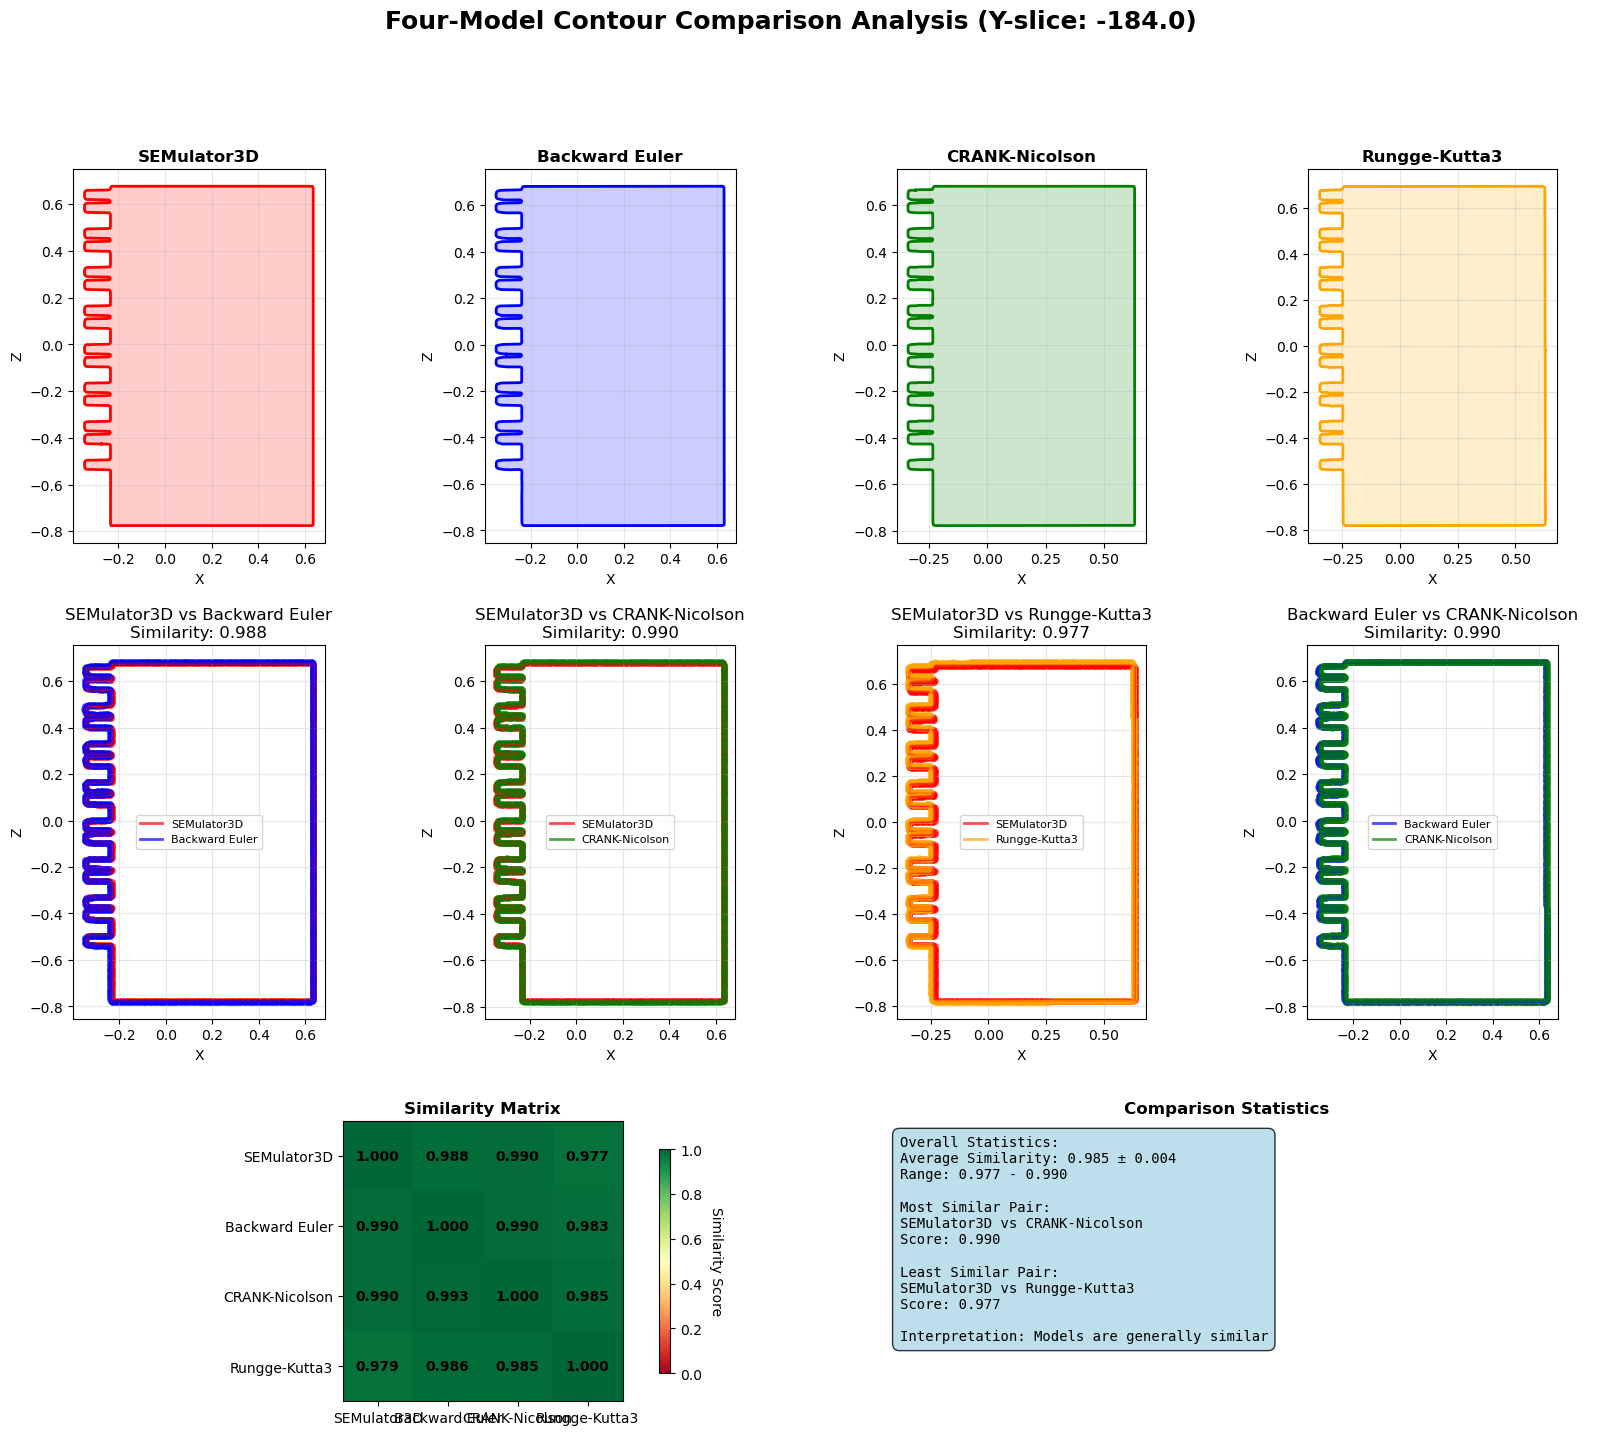


Detailed Similarity Report:
       Model_A        Model_B  Similarity_Score  Hausdorff_Distance  Area_Difference  Perimeter_Ratio  Shape_Context_Distance  Hu_Moments_Distance
   SEMulator3D Backward Euler            0.9880              0.0091           0.0083           0.9906                  0.0313               0.0018
   SEMulator3D CRANK-Nicolson            0.9904              0.0076           0.0044           0.9841                  0.0173               0.0034
   SEMulator3D  Rungge-Kutta3            0.9774              0.0232           0.0221           0.9667                  0.0266               0.0036
Backward Euler CRANK-Nicolson            0.9895              0.0096           0.0039           0.9935                  0.0279               0.0016
Backward Euler  Rungge-Kutta3            0.9831              0.0158           0.0140           0.9759                  0.0272               0.0018
CRANK-Nicolson  Rungge-Kutta3            0.9845              0.0187           0.0178     

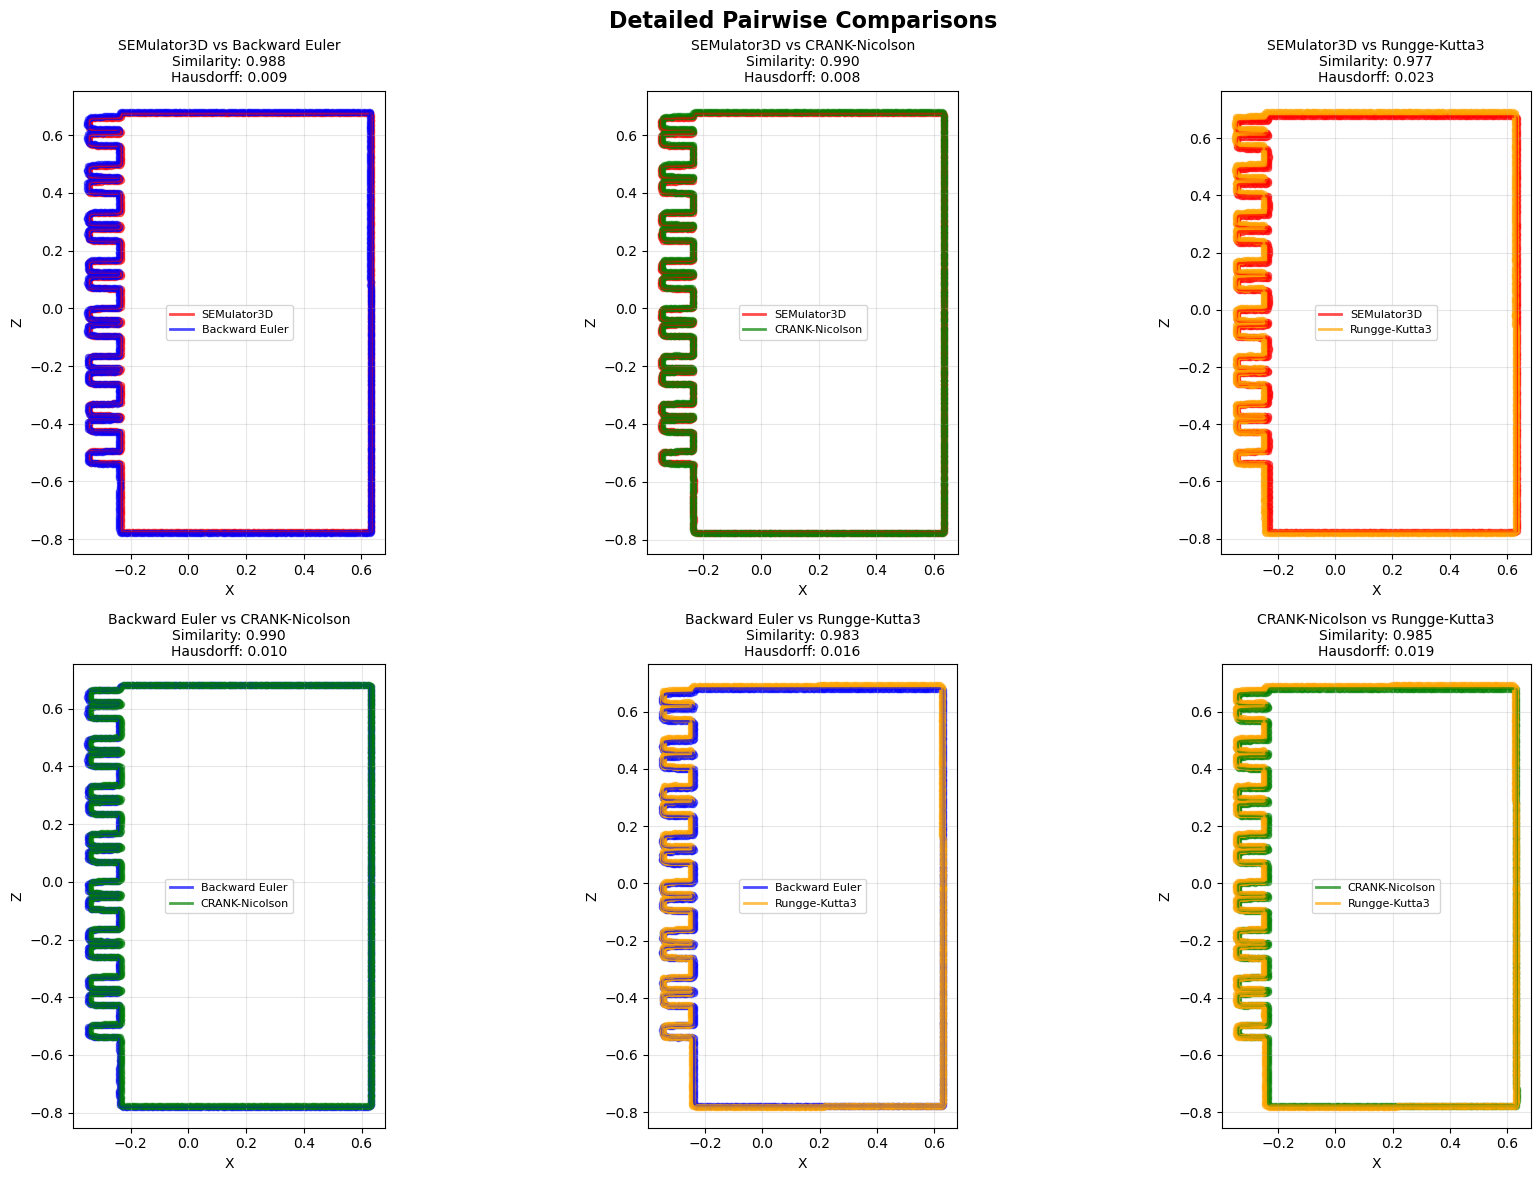


Most similar pair: SEMulator3D vs CRANK-Nicolson
Similarity score: 0.9904
Loading 4 meshes and extracting contours at Y = -38.0...
Loading SEMulator3D: ../initial_struct_600_600.off
Loading Backward Euler: ../remote/BACKWARD_EULER_64_Silicon_etch.off
Loading CRANK-Nicolson: ../remote/CRANK_NICOLSON_64_Silicon_etch.off
Loading Rungge-Kutta3: ../remote/RUNGE_KUTTA_3_2_Silicon_etch.off
Registering meshes for consistent alignment...
  Registered Backward Euler with cost: 0.0004
  Registered CRANK-Nicolson with cost: 0.0015
  Registered Rungge-Kutta3 with cost: 0.0028
  SEMulator3D: 1000 points extracted
  Backward Euler: 1000 points extracted
  CRANK-Nicolson: 1000 points extracted


/var/folders/yl/w2g1vm6x5rl_pppyvt9yfjk00000gn/T/ipykernel_8148/1820511793.py:29: DeprecationWarning: DEPRECATED: replace `path.to_planar`->`path.to_2D), removal 1/1/2026
  slice_2D, to_3D = slice_section.to_planar()


  Rungge-Kutta3: 1000 points extracted

Calculating similarity metrics for all pairs...
  Comparing SEMulator3D vs Backward Euler...
    Similarity: 0.992
  Comparing SEMulator3D vs CRANK-Nicolson...
    Similarity: 0.990
  Comparing SEMulator3D vs Rungge-Kutta3...
    Similarity: 0.983
  Comparing Backward Euler vs SEMulator3D...
    Similarity: 0.993
  Comparing Backward Euler vs CRANK-Nicolson...
    Similarity: 0.992
  Comparing Backward Euler vs Rungge-Kutta3...
    Similarity: 0.987
  Comparing CRANK-Nicolson vs SEMulator3D...
    Similarity: 0.992
  Comparing CRANK-Nicolson vs Backward Euler...
    Similarity: 0.993
  Comparing CRANK-Nicolson vs Rungge-Kutta3...
    Similarity: 0.990
  Comparing Rungge-Kutta3 vs SEMulator3D...
    Similarity: 0.983
  Comparing Rungge-Kutta3 vs Backward Euler...
    Similarity: 0.984
  Comparing Rungge-Kutta3 vs CRANK-Nicolson...
    Similarity: 0.986

Comparison Summary: 12/12 successful


/var/folders/yl/w2g1vm6x5rl_pppyvt9yfjk00000gn/T/ipykernel_8148/1820511793.py:357: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


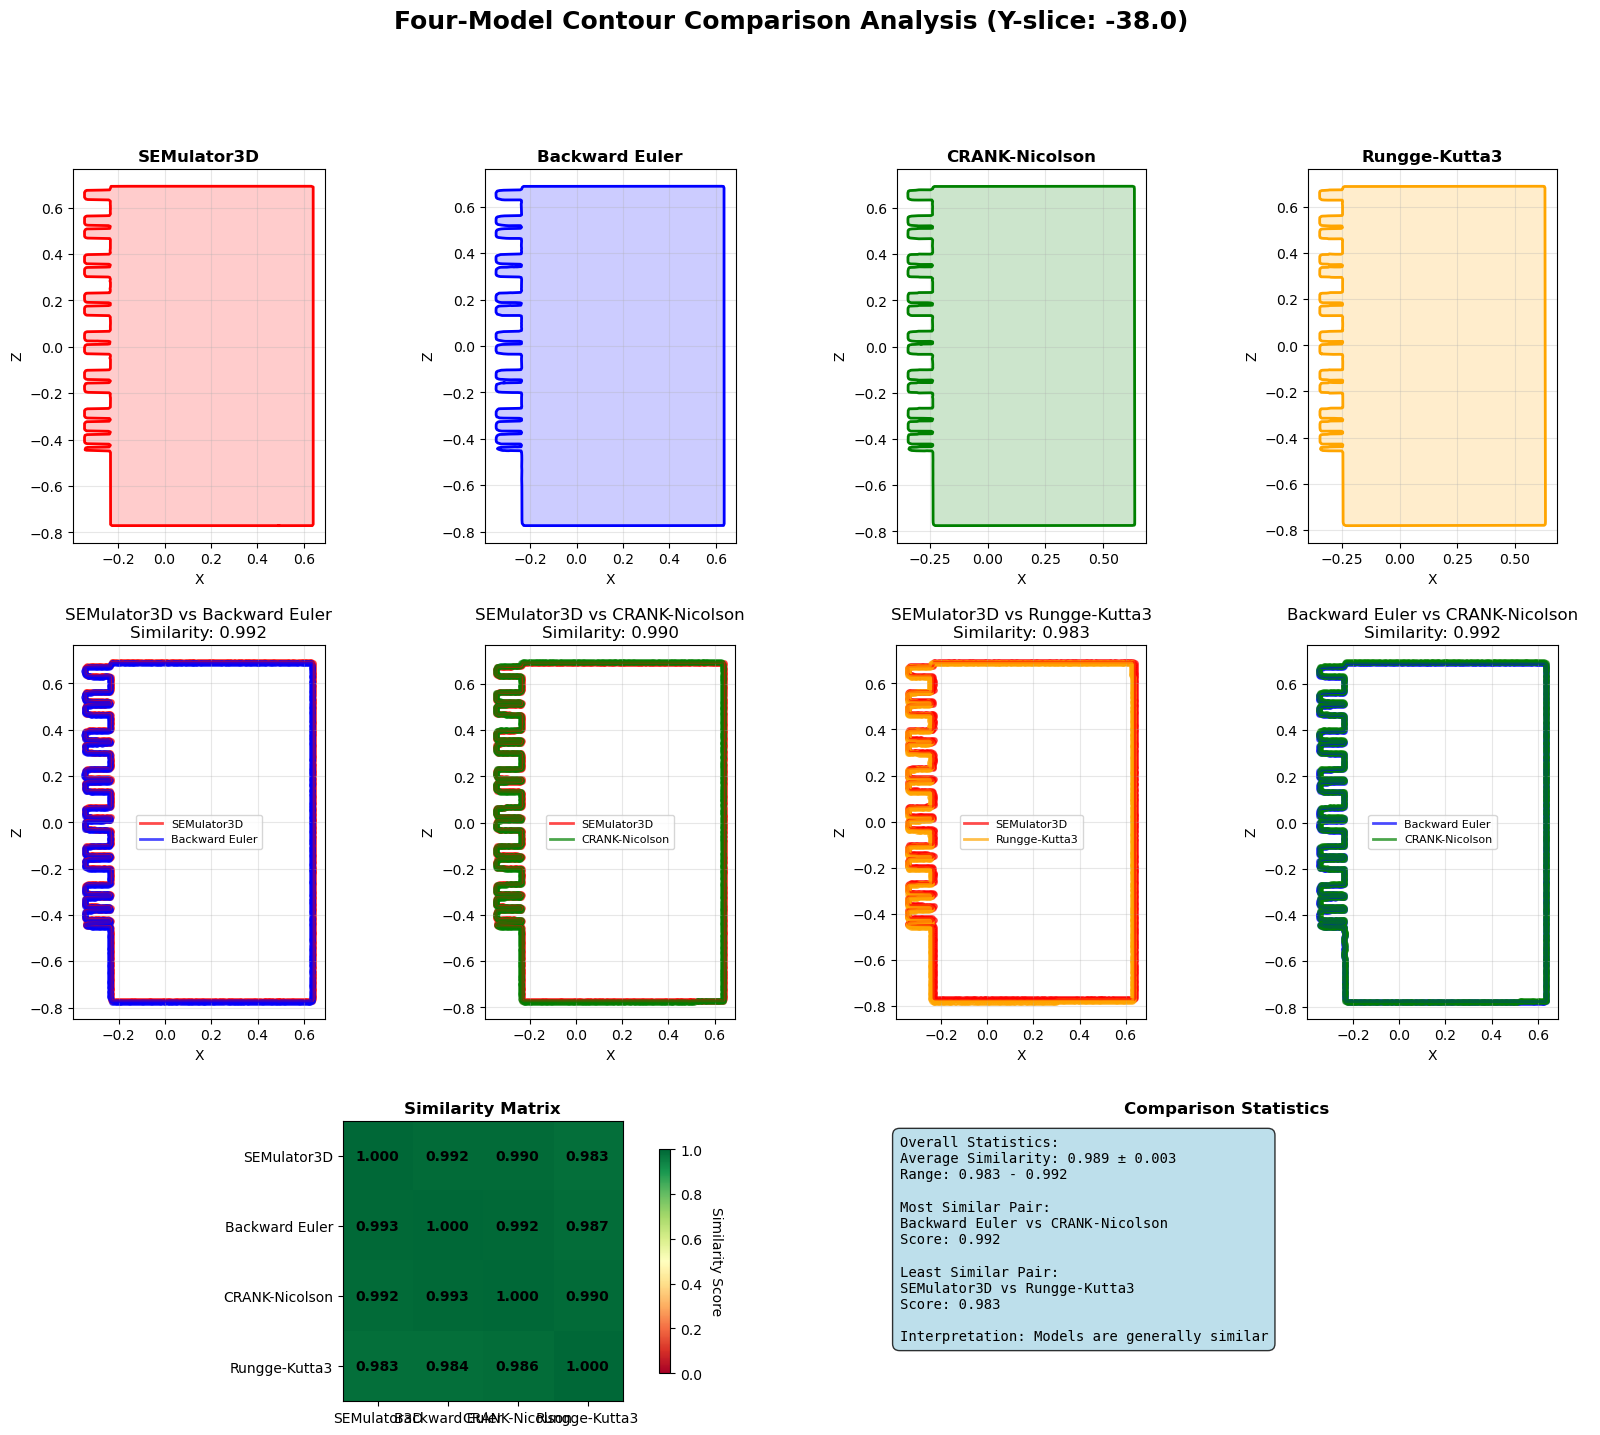


Detailed Similarity Report:
       Model_A        Model_B  Similarity_Score  Hausdorff_Distance  Area_Difference  Perimeter_Ratio  Shape_Context_Distance  Hu_Moments_Distance
   SEMulator3D Backward Euler            0.9921              0.0075           0.0019           0.9868                  0.0136               0.0020
   SEMulator3D CRANK-Nicolson            0.9898              0.0074           0.0018           0.9831                  0.0220               0.0039
   SEMulator3D  Rungge-Kutta3            0.9828              0.0158           0.0030           0.9582                  0.0180               0.0073
Backward Euler CRANK-Nicolson            0.9922              0.0071           0.0037           0.9963                  0.0203               0.0019
Backward Euler  Rungge-Kutta3            0.9875              0.0129           0.0049           0.9711                  0.0090               0.0053
CRANK-Nicolson  Rungge-Kutta3            0.9895              0.0123           0.0012     

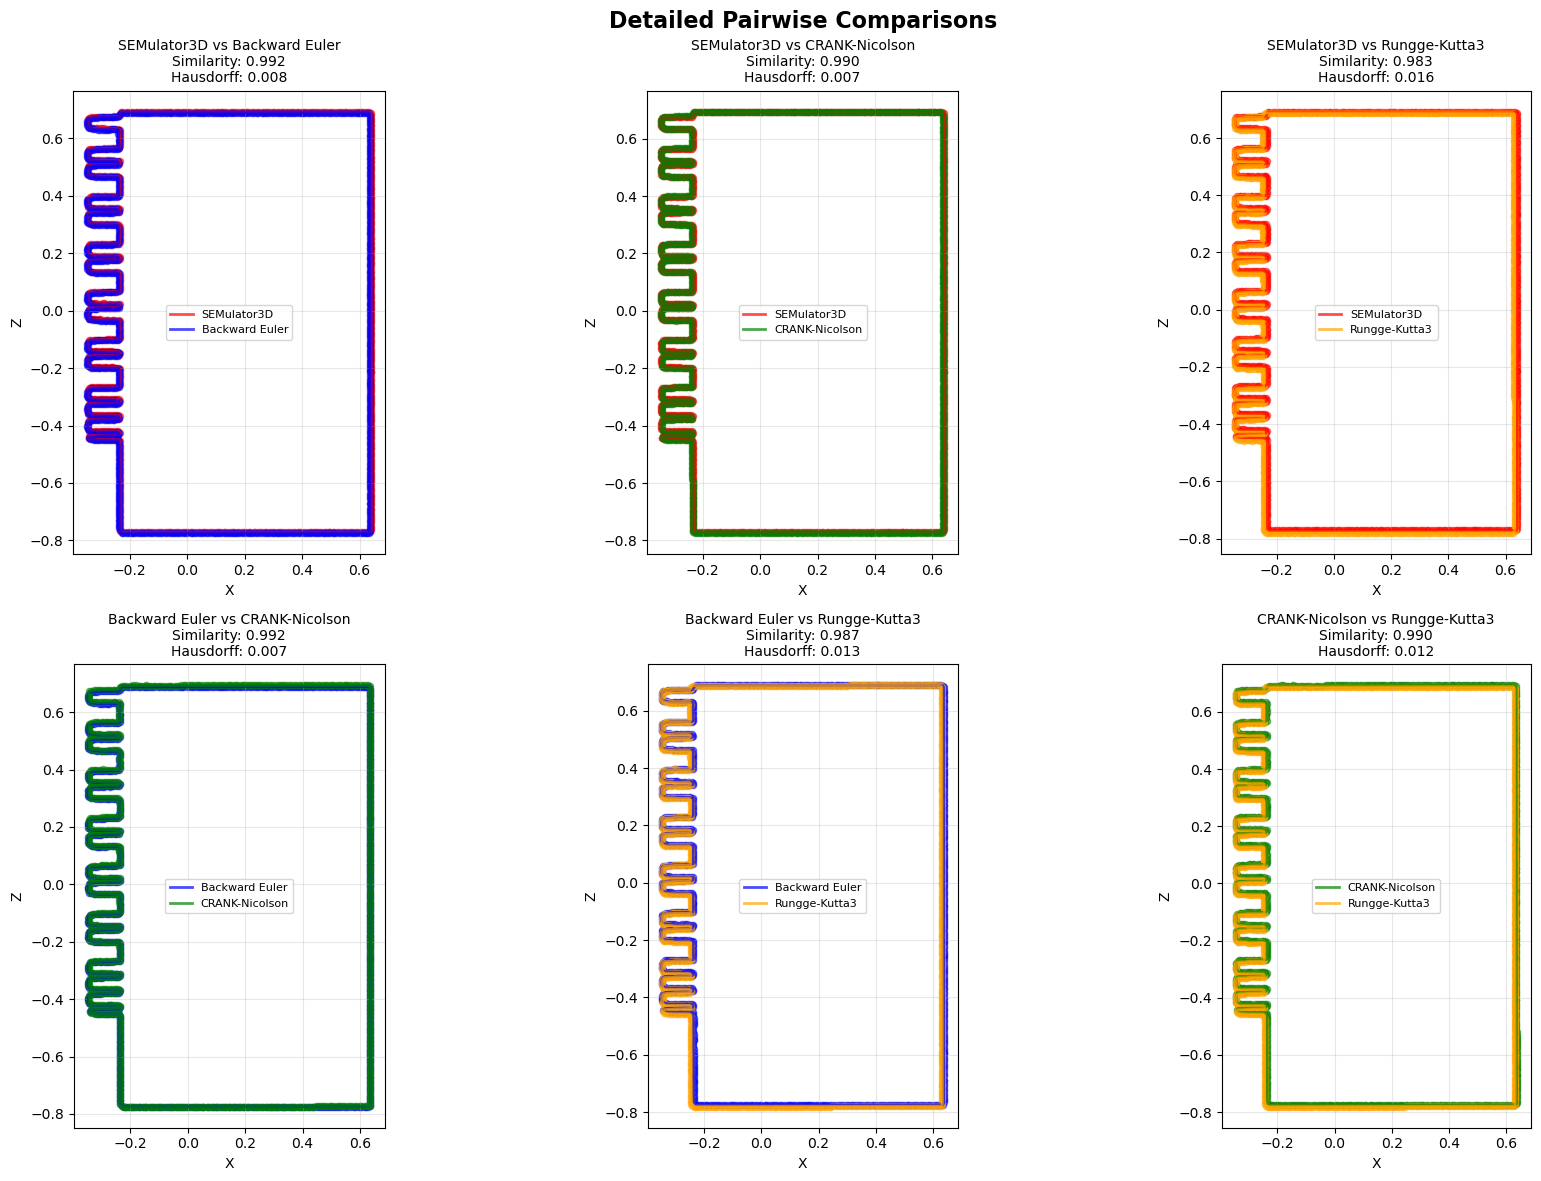


Most similar pair: Backward Euler vs CRANK-Nicolson
Similarity score: 0.9922
Loading 4 meshes and extracting contours at Y = 108.0...
Loading SEMulator3D: ../initial_struct_600_600.off
Loading Backward Euler: ../remote/BACKWARD_EULER_64_Silicon_etch.off
Loading CRANK-Nicolson: ../remote/CRANK_NICOLSON_64_Silicon_etch.off
Loading Rungge-Kutta3: ../remote/RUNGE_KUTTA_3_2_Silicon_etch.off
Registering meshes for consistent alignment...


In [ ]:
if __name__ == "__main__":
    # Replace with your actual .off file paths
    file_paths = [
		file1,
        file2, 
        file3,
        file4
    ]
    
    labels = ["SEMulator3D", "Backward Euler", "CRANK-Nicolson", "Rungge-Kutta3"]
    
    for i in np.linspace(-330, 400, 6):
 	   # Run the comparison
        results = compare_four_meshes(
			file_paths=file_paths,
			y_slice_value=i,  # Adjust this value based on your models
			labels=labels,
			num_points=1000
            )
        if results:
            plot_detailed_pairwise_comparisons(results)
            df = results['similarity_report']
            best_match = df.loc[df['Similarity_Score'].idxmax()]
            print(f"\nMost similar pair: {best_match['Model_A']} vs {best_match['Model_B']}")
            print(f"Similarity score: {best_match['Similarity_Score']:.4f}")